In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import copy
import scipy.linalg
from scipy.optimize import curve_fit
from scipy.stats import chi2


# Problem 1

1. Use least squares to fit the line intensities in the spectrum HII_R500.fits, which is a simulated spectrum of the region around the lines at a spectral  resolution of R=500. You can assume that the intrinsic width of the lines are unresolved at this resolution, so the width of the lines is known and set by the spectral resolution. In this case, since you also know the wavelengths of the three lines (6548.3,6562.8,6583.41), the only unknown are the line intensities (the amplitude), so this is a linear fit.

a. Write a routine to do the linear least squares. This should return 1) the best fit intensities of the lines, 2) their uncertainties, and 3) a quantitative estimate of goodness of fit, e.g. chi^2 and the probability of getting this chi^2.  You can use whatever routines you want to do the fitting, including the canned numpy/scipy routines presented in class in the leastsquares notebook, (Links to an external site.) e.g. scipy.linalg.lstsq() or the numpy.linalg linear algebra routines.

b. Test it by generating your own spectra using your specsim routine from the data simulation notebook, for various different input parameters. Document your results.



In [2]:
# set up our output wavelengths for our underlying intrinsic spectrum
lambdastart = 6500
lambdaend = 6600
dlambda = 0.01   # set appropriate dlambda (=A/pixel), you can round to a simple number
waves = np.arange(lambdastart,lambdaend,dlambda)
spec = np.zeros(waves.shape)
c = 3e5 #km/s
R = 500 # Resolution

In [3]:
def gauss(x,mean=0,sig=1) :
    """ Return normalized Gaussian function here"""
    return  (1/(sig*np.sqrt(2*np.pi))) * np.exp((-(x-mean)**2)/(2*sig**2))


In [4]:
def mkline(waves,wline,vel_width,amp) :
    """ routine to return array with a simulated emission line, given :
        wave:  wavelengths corresponding to spectral array pixels
        wline: wavelength of the line to add
        vel_width: velocity width (km/s) of line to add
        amp: amplitude of line
        """
    
    dl = (wline/c)*vel_width   # what delta lambda (FWHM) does the velocity width correspond to?
    sigma = dl/2.354            # what gaussian sigma does this correspond to?
    # we will add in the contribution of the line to every output pixel, although in practice this is
    # very wasteful, since the line is only going to contribute out to a few FWHM!
    out = amp*gauss(waves,mean=wline,sig=sigma)   # add in appropriate flux
    return out


In [5]:
def get_kernel(waves,R) :
    ''' Create a Gaussian smoothing kernel for a given input wavelength array and a resolution R
    '''
    wcen = waves[int(len(waves)/2)]     # wavelength center
    dl=  wcen/R                             # set correspoding delta lambda corresponding to R at middle of range
    dlambda=waves[1]-waves[0]           # making assumption that our array is spaced by constant in wavelength!
    dl_pixels = dl / dlambda                          # we want kernel in pixel space, so convert to delta lambda in pixels
    sig_pixels = int(dl_pixels / 2.354) # convert to Gaussian sigma, make it be an integer number of pixels
    print('Kernel Delta lambda:',dl)
    print('Kernel sigma in pixels: ',sig_pixels)
    x=np.arange(-5*sig_pixels,5*sig_pixels+1)  # set kernel to go from -5 sigma to 5 sigma, with an odd number of pixels
    kernel=  gauss(x,sig=sig_pixels)                            # populate kernel using our gaussian routine
    return kernel


In [6]:
def specsim(waves,spec,R,samples=3,sky=1,sn=10,rn=3) :
    """ given input wavelength and spectrum, create 'observed' spectrum
        waves: input wavelength array
        spec : input spectrum
        R : desired resolution
        samples : desired sampling (samples pixels per resolution element)
        sky : sky level to add (in same units as spec)
        sn : scale levels for a mean S/N
        rn : readout noise
    """
    kernel=get_kernel(waves,R=R)     # get the smoothing kernel
    smoothed=np.convolve(spec,kernel,mode='same')  # convolve
    wcen = waves[int(len(waves)/2)]     # wavelength center
    dl_desired = wcen/R/samples         # what is the corresponding wavelength spacing
    nskip = int(dl_desired / (waves[1]-waves[0]))   #determine sampling of input array
    out=smoothed[::nskip] + sky       # sample and add sky
    level=sn**2                       # desired level, given S/N
    out*= level/np.median(out)        # scale to desired level
    final=np.random.poisson(out)+np.random.normal(0,rn,size=len(out))   # add Poisson and readout noise
    return waves[::nskip],final


    

# Test 1

Kernel Delta lambda: 13.100000000002183
Kernel sigma in pixels:  556


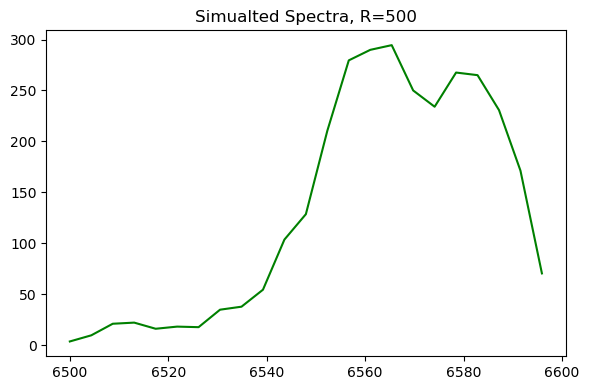

In [7]:
lines=[6548.3,6562.8,6583.41]   # [NII]6548, Ha6563, [NII]6583
amps=[100,300,300]            # relative amplitudes here
# the width of the lines is known and set by the spectral resolution
velwidths=[c/R,c/R,c/R]            # velocity widths
spec=np.zeros(len(waves))
for line,amp,vel in zip(lines,amps,velwidths) :
    spec+=mkline(waves,line,vel,amp)    # add in each line

# simulate the observed spectrum
plt.figure(dpi=100)
plt.title('Simualted Spectra, R=500')
waves_out_sim,out_sim=specsim(waves,spec,R,sky=1,sn=10,rn=3)
plt.plot(waves_out_sim,out_sim,color='g')
plt.tight_layout()
plt.show()

In [9]:
# linear fit
# find line intensities (amplitude)

def func(x,par,mean_f,sig_f) :
    """ Return normalized Gaussian functions. One for each of the lines.
    
    Input:
    x = wavelength array
    par = line intensities; amplitude; unknown variables
    mean_f = mean array (the wavelengths of each line)
    sig_f = standard deviation array of each line determined by FWHM
    
    Output:
    G1+G2+G3 = the added gaussian functions
    """
    
 
    G1 = par[0]*np.exp((-(x-mean_f[0])**2)/(2*sig_f[0]**2))
    G2 = par[1]*np.exp((-(x-mean_f[1])**2)/(2*sig_f[1]**2)) 
    G3 = par[2]*np.exp((-(x-mean_f[2])**2)/(2*sig_f[2]**2)) 
    
    return  G1+G2+G3


def deriv(x,mean_f,sig_f):
    """ Derivatives with respect to each parameter
    
    Input:
    x = wavelength array
    mean_f = mean array (the wavelengths of each line)
    sig_f = standard deviation array of each line determined by FWHM
    
    Output:
    np.array([G1,G2,G3]) = the added gaussian functions
    """

    

    G1 = np.exp((-(x-mean_f[0])**2)/(2*sig_f[0]**2))
    G2 = np.exp((-(x-mean_f[1])**2)/(2*sig_f[1]**2))
    G3 = np.exp((-(x-mean_f[2])**2)/(2*sig_f[2]**2))
    return np.array([G1,G2,G3])


# wavelengths of each line
mean_r=np.array([6548.3,6562.8,6583.41])
#FWHM
dl = np.array(mean_r)/R
sig_func=np.array(dl/2.354)

# simulated spectra 
# uncertainities & read out noise
sig_sim =  np.sqrt(out_sim + 3**2)
y_sim = out_sim
x_sim = waves_out_sim


In [10]:
# due to there being 3 amplitudes for 3 different guassian lines
npar = 3
beta=np.zeros(npar)
alpha=np.zeros([npar,npar])
for k in np.arange(npar) :
    beta[k] = (deriv(x_sim,mean_r,sig_func)[k]*y_sim/sig_sim**2).sum()
    for j in np.arange(npar) :
        alpha[j,k] = (deriv(x_sim,mean_r,sig_func)[j]*deriv(x_sim,mean_r,sig_func)[k]/sig_sim**2).sum()
print('alpha:')
print(alpha)
print('beta')
print(beta)


alpha:
[[1.58532021e-02 1.69643334e-03 3.97217696e-07]
 [1.69643334e-03 7.73950298e-03 2.92735532e-04]
 [3.97217696e-07 2.92735532e-04 8.93014353e-03]]
beta
[2.98359327 3.10283779 3.08192846]


pars:  [150.16392647 355.38192    333.45890708]
inverse matrix: 
[[ 64.59571767 -14.17630107   0.46183451]
 [-14.17630107 132.47882208  -4.34210572]
 [  0.46183451  -4.34210572 112.12259936]]
uncertainties on individual parameters from sqrt of diagonal
8.037146114833401 11.509944486495595 10.58879593555788


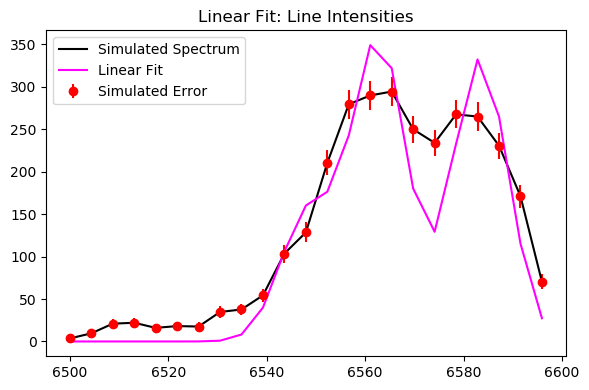

In [11]:
# now invert the matrix alpha, and multiply by beta to get the parameters
c=np.linalg.inv(alpha)
par_derived=np.dot(c,beta)
print('pars: ',par_derived)

# uncertainties from inverse matrix
print('inverse matrix: ')
print(c)
print('uncertainties on individual parameters from sqrt of diagonal')
print(np.sqrt(c[0,0]),np.sqrt(c[1,1]),np.sqrt(c[2,2]))


plt.figure(dpi=100)
plt.title('Linear Fit: Line Intensities')
plt.errorbar(x_sim,y_sim,sig_sim,fmt='ro',label = 'Simulated Error')
plt.plot(x_sim,y_sim,label='Simulated Spectrum',color='black')
plt.plot(x_sim,func(x_sim,par_derived,mean_r,sig_func),label='Linear Fit',color='magenta')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [12]:
freedom = (len(y_sim) - npar)
chi=sum((y_sim-func(x_sim,par_derived,mean_r,sig_func))**2/sig_sim**2)

print(chi,chi2.cdf(chi,len(y_sim)-npar))

280.29349187150626 1.0


For a simulated spectra of R=500, sky = 1, S/N = 10, and RN = 3, the derived line intenities for each line are 163.69, 348.86, and 343.649, respectively.
Their uncertainties are 8.32,11.45, and 10.74, respectively. The $\chi^2$ value is 275 with a probability of 1.

--------

# Test 2

Kernel Delta lambda: 13.100000000002183
Kernel sigma in pixels:  556


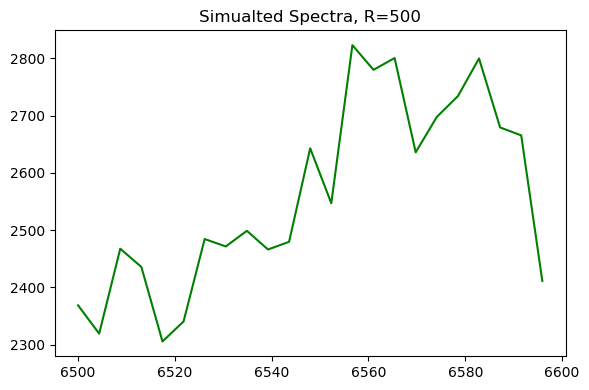

In [25]:
R = 500
c = 3e5 #km/s
 
lines=[6548.3,6562.8,6583.41]   # [NII]6548, Ha6563, [NII]6583
amps=[100,300,300]            # relative amplitudes here
# the width of the lines is known and set by the spectral resolution
velwidths=[c/R,c/R,c/R]            # velocity widths
spec=np.zeros(len(waves))
for line,amp,vel in zip(lines,amps,velwidths) :
    spec+=mkline(waves,line,vel,amp)    # add in each line

# simulate the observed spectrum
plt.figure(dpi=100)
plt.title('Simualted Spectra, R=500')
waves_out_sim,out_sim=specsim(waves,spec,R,sky=100,sn=50,rn=3)
plt.plot(waves_out_sim,out_sim,color='g')
plt.tight_layout()
plt.show()

In [26]:
# wavelengths of each line
mean_r=np.array([6548.3,6562.8,6583.41])
#FWHM
dl = np.array(mean_r)/R
sig_func=np.array(dl/2.354)

# simulated spectra 
# uncertainities & read out noise
sig_sim =  np.sqrt(out_sim + 3**2)
y_sim = out_sim
x_sim = waves_out_sim


alpha:
[[8.72770611e-04 1.53093173e-04 4.11725326e-08]
 [1.53093173e-04 8.14264148e-04 2.79003996e-05]
 [4.11725326e-08 2.79003996e-05 8.26935370e-04]]
beta
[3.18746525 3.19520346 3.19378721]
pars:  [3088.03039722 3214.82999407 3753.57632143]
inverse matrix: 
[[1184.8985109  -223.03349385    7.46604698]
 [-223.03349385 1271.5057198   -42.88888355]
 [   7.46604698  -42.88888355 1210.73102686]]
uncertainties on individual parameters from sqrt of diagonal
34.422354813385724 35.6581788626405 34.79556044754388


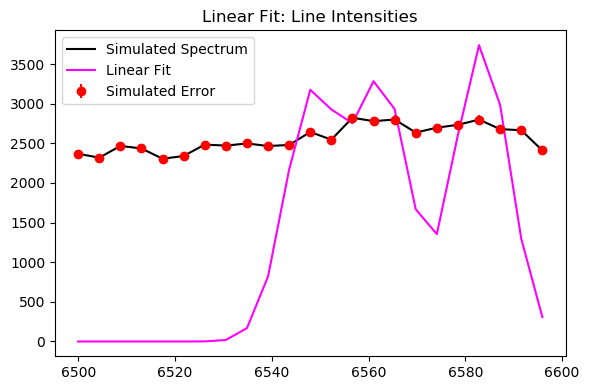

26545.26035772563 1.0


In [31]:
# due to there being 3 amplitudes for 3 different guassian lines
npar = 3
beta=np.zeros(npar)
alpha=np.zeros([npar,npar])
for k in np.arange(npar) :
    beta[k] = (deriv(x_sim,mean_r,sig_func)[k]*y_sim/sig_sim**2).sum()
    for j in np.arange(npar) :
        alpha[j,k] = (deriv(x_sim,mean_r,sig_func)[j]*deriv(x_sim,mean_r,sig_func)[k]/sig_sim**2).sum()
print('alpha:')
print(alpha)
print('beta')
print(beta)


# now invert the matrix alpha, and multiply by beta to get the parameters
c=np.linalg.inv(alpha)
par_derived=np.dot(c,beta)
print('pars: ',par_derived)

# uncertainties from inverse matrix
print('inverse matrix: ')
print(c)
print('uncertainties on individual parameters from sqrt of diagonal')
print(np.sqrt(c[0,0]),np.sqrt(c[1,1]),np.sqrt(c[2,2]))


plt.figure(dpi=100)
plt.title('Linear Fit: Line Intensities')
plt.errorbar(x_sim,y_sim,sig_sim,fmt='ro',label = 'Simulated Error')
plt.plot(x_sim,y_sim,label='Simulated Spectrum',color='black')
plt.plot(x_sim,func(x_sim,par_derived,mean_r,sig_func),label='Linear Fit',color='magenta')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

freedom = (len(y_sim) - npar)
chi=sum((y_sim-func(x_sim,par_derived,mean_r,sig_func))**2/sig_sim**2)

print(chi,chi2.cdf(chi,len(y_sim)-npar))

Something I have noticed is that if you increase the sky level, the fit is not that good.


For a simulated spectra of R=500, sky = 100, S/N = 50, and RN = 3, the derived line intenities for each line are 3088.03, 3214.82, and 3753.57 respectively. Their uncertainties are 34.42, 35.65, and 34.79, respectively. The $\chi^2$ value is 26545 with a probability of 1.

----------

# Test 3

Kernel Delta lambda: 13.100000000002183
Kernel sigma in pixels:  556


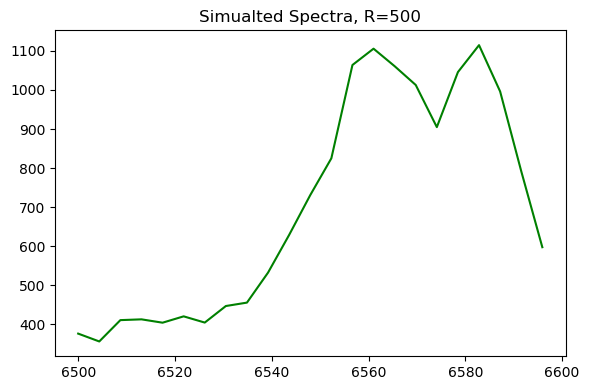

In [35]:
R = 500
c = 3e5 #km/s
 
lines=[6548.3,6562.8,6583.41]   # [NII]6548, Ha6563, [NII]6583
amps=[100,300,300]            # relative amplitudes here
# the width of the lines is known and set by the spectral resolution
velwidths=[c/R,c/R,c/R]            # velocity widths
spec=np.zeros(len(waves))
for line,amp,vel in zip(lines,amps,velwidths) :
    spec+=mkline(waves,line,vel,amp)    # add in each line

# simulate the observed spectrum
plt.figure(dpi=100)
plt.title('Simualted Spectra, R=500')
waves_out_sim,out_sim=specsim(waves,spec,R,sky=10,sn=25,rn=3)
plt.plot(waves_out_sim,out_sim,color='g')
plt.tight_layout()
plt.show()

alpha:
[[3.06443614e-03 4.33825238e-04 1.07299128e-07]
 [4.33825238e-04 2.10361771e-03 7.67082781e-05]
 [1.07299128e-07 7.67082781e-05 2.17746046e-03]]
beta
[3.15926722 3.17812258 3.17540849]
pars:  [ 849.1013939  1284.15444573 1413.02777367]
inverse matrix: 
[[336.1507665  -69.41232148   2.42871504]
 [-69.41232148 490.31605507 -17.26959139]
 [  2.42871504 -17.26959139 459.85884832]]
uncertainties on individual parameters from sqrt of diagonal
18.33441481207588 22.14308142662528 21.44431972161129


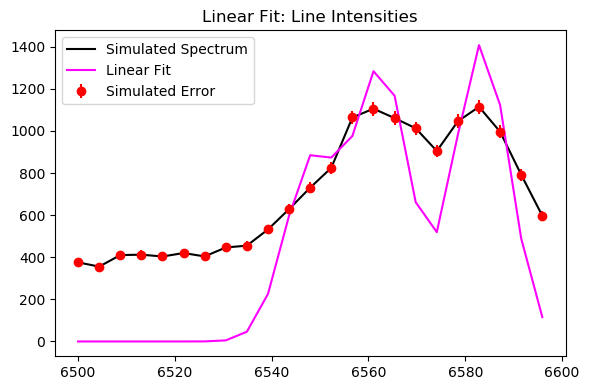

4640.25436806217 1.0


In [36]:
# wavelengths of each line
mean_r=np.array([6548.3,6562.8,6583.41])
#FWHM
dl = np.array(mean_r)/R
sig_func=np.array(dl/2.354)

# simulated spectra 
# uncertainities & read out noise
sig_sim =  np.sqrt(out_sim + 3**2)
y_sim = out_sim
x_sim = waves_out_sim


# due to there being 3 amplitudes for 3 different guassian lines
npar = 3
beta=np.zeros(npar)
alpha=np.zeros([npar,npar])
for k in np.arange(npar) :
    beta[k] = (deriv(x_sim,mean_r,sig_func)[k]*y_sim/sig_sim**2).sum()
    for j in np.arange(npar) :
        alpha[j,k] = (deriv(x_sim,mean_r,sig_func)[j]*deriv(x_sim,mean_r,sig_func)[k]/sig_sim**2).sum()
print('alpha:')
print(alpha)
print('beta')
print(beta)


# now invert the matrix alpha, and multiply by beta to get the parameters
c=np.linalg.inv(alpha)
par_derived=np.dot(c,beta)
print('pars: ',par_derived)

# uncertainties from inverse matrix
print('inverse matrix: ')
print(c)
print('uncertainties on individual parameters from sqrt of diagonal')
print(np.sqrt(c[0,0]),np.sqrt(c[1,1]),np.sqrt(c[2,2]))


plt.figure(dpi=100)
plt.title('Linear Fit: Line Intensities')
plt.errorbar(x_sim,y_sim,sig_sim,fmt='ro',label = 'Simulated Error')
plt.plot(x_sim,y_sim,label='Simulated Spectrum',color='black')
plt.plot(x_sim,func(x_sim,par_derived,mean_r,sig_func),label='Linear Fit',color='magenta')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

freedom = (len(y_sim) - npar)
chi=sum((y_sim-func(x_sim,par_derived,mean_r,sig_func))**2/sig_sim**2)

print(chi,chi2.cdf(chi,len(y_sim)-npar))

For a simulated spectra of R=500, sky = 10, S/N = 25, and RN = 3, the derived line intenities for each line are 849.10, 1284.15, and 1413.02, respectively. Their uncertainties are 18.33, 22.14, and 21.44, respectively. The $\chi^2$ value is 4640 with a probability of 1.


------------

c. Recall that the [NII] lines come in a ratio of [1:3] from atomic physics. Can you make use of this to improve the accuracy of your fits?

I have been making use of this. My relative amplitudes used when computing the simulated spectra is 100,300, and 300. The linear fit looks better when the sky level is really low; however, once you increase the sky level and S/N, the fit is not good.

----------------------

d. Use your routine to derive line intensities for HII_R500.fits (Links to an external site.). For those of you who have not worked with FITS files, you can read them using the astropy fits module: from astropy import fits, a=fits.open('HII_R500.fits'). The spectrum will be in the a[0].data attribute. The wavelengths can be determined from header cards in the a[0].header attribute:  waves=a[0].header['CRVAL1']+a[0].header['CDELT1']*np.arange(a[0].header['NAXIS1']). You should assume that the units of the spectrum is in detected electrons, so you can calculate the expected uncertainties; on top of the Poisson noise, you can assume a readout noise of 3 electrons.

In [37]:
# fits file data
HII_R500_file = fits.open('HII_R500.fits')
HII_R500_file2 = HII_R500_file[0].data

# fits file wavlength
waves2=HII_R500_file[0].header['CRVAL1']+HII_R500_file[0].header['CDELT1']*np.arange(HII_R500_file[0].header['NAXIS1'])


alpha:
[[8.47149729e-04 1.30176951e-04 3.15652310e-08]
 [1.30176951e-04 6.01390681e-04 2.52411031e-05]
 [3.15652310e-08 2.52411031e-05 6.94502153e-04]]
beta
[3.18785406 3.19754557 3.19518957]
pars:  [3076.8135674  4464.63201454 4438.28748148]
inverse matrix: 
[[1221.1069459  -264.72213541    9.56560633]
 [-264.72213541 1722.741697    -62.59958246]
 [   9.56560633  -62.59958246 1442.15504006]]
uncertainties on individual parameters from sqrto of diagonal
34.94434068484014 41.50592363751919 37.97571645225591


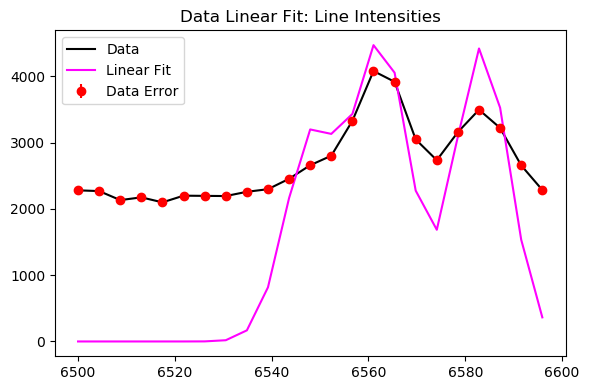

23502.112443678223 1.0


In [40]:
# due to there being 3 amplitudes for 3 different guassian lines
y_fits = HII_R500_file2
sig_fits = np.sqrt(y_fits + 3**2)
x_fits = waves2

npar = 3
beta=np.zeros(npar)
alpha=np.zeros([npar,npar])
for k in np.arange(npar) :
    beta[k] = (deriv(x_fits,mean_r,sig_func)[k]*y_fits/sig_fits**2).sum()
    for j in np.arange(npar) :
        alpha[j,k] = (deriv(x_fits,mean_r,sig_func)[j]*deriv(x_fits,mean_r,sig_func)[k]/sig_fits**2).sum()
print('alpha:')
print(alpha)
print('beta')
print(beta)

# now invert the matrix alpha, and multiply by beta to get the parameters
c=np.linalg.inv(alpha)
par_derived=np.dot(c,beta)
print('pars: ',par_derived)

# uncertainties from inverse matrix
print('inverse matrix: ')
print(c)
print('uncertainties on individual parameters from sqrto of diagonal')
print(np.sqrt(c[0,0]),np.sqrt(c[1,1]),np.sqrt(c[2,2]))


plt.figure(dpi=100)
plt.title('Data Linear Fit: Line Intensities')

plt.errorbar(x_fits,y_fits,sig_fits,fmt='ro', label='Data Error')
plt.plot(x_fits,y_fits,color='black',label='Data')
plt.plot(x_fits,func(x_fits,par_derived,mean_r,sig_func),color='magenta',label='Linear Fit')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

freedom = (len(y_fits) - npar)
chi=sum((y_fits-func(x_fits,par_derived,mean_r,sig_func))**2/sig_fits**2)

print(chi,chi2.cdf(chi,len(y_fits)-npar))


The derived line intensities for the fits file data are 3076.81, 4464.63, and 4438.28, respectively. Their uncertainities are 34.94, 41.50, and 37.97, respectively. The $\chi^2$ value is 23502 with a probability of 1.

---------------------

2. Use least squares to fit the line intensities and line widths in the spectrum AGN_R3000.fits (Links to an external site.), which is a simulated spectrum of the region around the lines at a spectral  resolution of R=3000. At this resolution, the intrinsic width of the lines is resolved, especially since this is a simulation of an AGN which can have broad lines. In this case, you need to solve for both the intensities of the lines as well as the line widths, recognizing that the forbidden [NII] lines may not have the same velocity width as the Halpha line (but the two [NII] lines have the same velocity width). Since the widths of the lines are a free parameter, this is a nonlinear fit.

a. Write a routine to do the nonlinear least squares. This should return 1) the best fit intensities of the lines, 2) their uncertainties, and 3) a quantitative estimate of goodness of fit, e.g. chi^2 and the probability of getting this chi^2.  You can use whatever routines you want to do the fitting, including the canned scipy.optimize.curve_fit() routine presented in class in the leastsquares notebook. You will need to provide a starting guess for the algorithm: describe how you made your initial guess, and run a few experiments to determine to what extent the result is sensitive to the starting guess.

b. Test it by generating your own spectra using your specsim routine from the data simulation notebook, for various different input parameters. Document your results.

------------

# Test 1

Kernel Delta lambda: 2.1833333333336973
Kernel sigma in pixels:  92


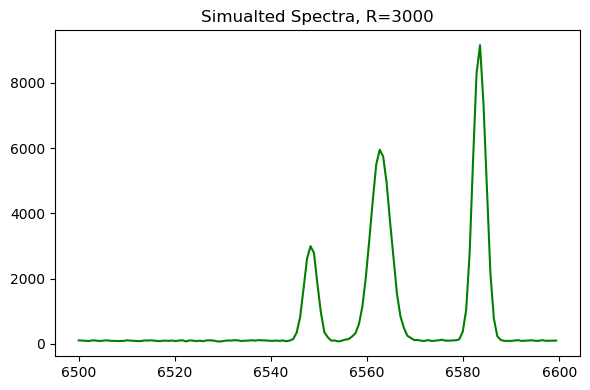

In [44]:
R = 3000
c = 3e5 #km/s
 
lines=[6548.3,6562.8,6583.41]   # [NII]6548, Ha6563, [NII]6583
amps=[100,300,300]            # relative amplitudes here
velwidths=[100,200,100]            # velocity widths
spec=np.zeros(len(waves))
for line,amp,vel in zip(lines,amps,velwidths) :
    spec+=mkline(waves,line,vel,amp)    # add in each line

plt.figure(dpi=100)
# simulate the observed spectrum
plt.title('Simualted Spectra, R=3000')
waves_out_sim,out_sim=specsim(waves,spec,R,sky=1,sn=10,rn=3)
plt.plot(waves_out_sim,out_sim,color='g')
plt.tight_layout()
plt.show()

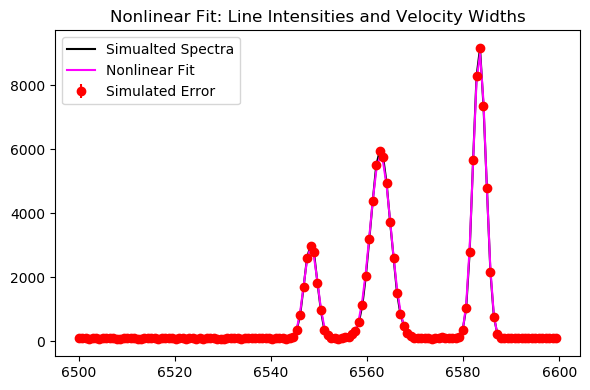

Derived Parameters: [2.94007055e+03 5.77624891e+03 9.00832516e+03 1.45116606e+00
 2.17622607e+00 1.36470753e+00]
Errors on the parameters: [2.51870510e+02 2.86124285e+02 4.45851657e+02 7.74421173e-02
 6.61400121e-02 4.05604990e-02]
8955.345314618135 1.0


In [56]:
# fitting begins here
# nonlinear fit
# finding line intensities and velocity widths

def func_new(x,par1,par2,par3,par4,par5,par6) :
    """ Return normalized Gaussian function here for each of the 3 wavelengths.
    
    Input:
    x = wavelength array
    par1 = amplitude of 1st wave
    par2 = amplitude of 2nd wave
    par3 = amplitude of 3rd wave
    par4 = width of 1st wave
    par5 = width of 2nd wave
    par6 = width of 3rd wave
    
    Output:
    G1+G2+G3 = the added gaussian functions
    """
    

    G1 = par1*np.exp((-(x-6548.3)**2)/(2*par4**2))
    G2 = par2*np.exp((-(x-6562.8)**2)/(2*par5**2)) 
    G3 = par3*np.exp((-(x-6583.41)**2)/(2*par6**2)) 
    
    return  G1+G2+G3


# initial guesses
init = np.array([4000,6000,9000,7,10,6])
y_sim = out_sim
x_sim = waves_out_sim
sig_d = np.sqrt(y_sim + 3**2)

# curve fit process
popt, pcov = curve_fit(func_new,x_sim,y_sim,p0=init,sigma=sig_d,bounds=([1e3,1e3,1e3,0.1,0.1,0.1],[1e5,1e5,1e5,11,11,11]))

npar=6
freedom = (len(y_sim) - npar)
chi=sum((y_sim-func_new(x_sim,*popt))**2/sig_d**2)


plt.figure(dpi=100)
plt.title('Nonlinear Fit: Line Intensities and Velocity Widths')
plt.errorbar(x_sim,y_sim,sig_d,fmt='ro', label="Simulated Error")
plt.plot(x_sim,y_sim, color = 'black', label='Simualted Spectra')
plt.plot(x_sim,func_new(x_sim,*popt), color='magenta', label='Nonlinear Fit')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# errors on the diagonal
perr = np.sqrt(np.diag(pcov))
print('Derived Parameters:',popt)
print('Errors on the parameters:',perr)

print(chi,chi2.cdf(chi,len(out)-6))

For a simulated spectra of R=3000, sky = 1, S/N = 10, and RN = 3, the derived line intenities for each line are 
2.94007055e+03, 5.77624891e+03, and 9.00832516e+03 and their derived velocity widths are 1.45116606e+00, 2.17622607e+00, and 1.36470753e+00, respectively. The uncertainties are the parameters are 2.51870510e+02, 2.86124285e+02, 4.45851657e+02, 7.74421173e-02, 6.61400121e-02, and 4.05604990e-02, respectively.
The $\chi^2$ value is 8955 with a probability of 1.

--------------

# Test 2

Kernel Delta lambda: 2.1833333333336973
Kernel sigma in pixels:  92


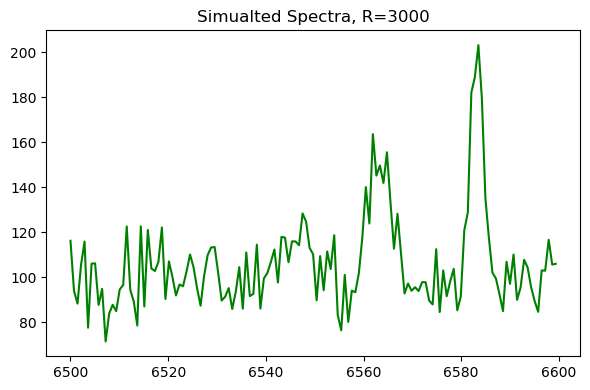

In [57]:
R = 3000
c = 3e5 #km/s
 
lines=[6548.3,6562.8,6583.41]   # [NII]6548, Ha6563, [NII]6583
amps=[100,300,300]            # relative amplitudes here
velwidths=[100,200,100]            # velocity widths
spec=np.zeros(len(waves))
for line,amp,vel in zip(lines,amps,velwidths) :
    spec+=mkline(waves,line,vel,amp)    # add in each line

plt.figure(dpi=100)
# simulate the observed spectrum
plt.title('Simualted Spectra, R=3000')
waves_out_sim,out_sim=specsim(waves,spec,R,sky=100,sn=10,rn=3)
plt.plot(waves_out_sim,out_sim,color='g')
plt.tight_layout()
plt.show()

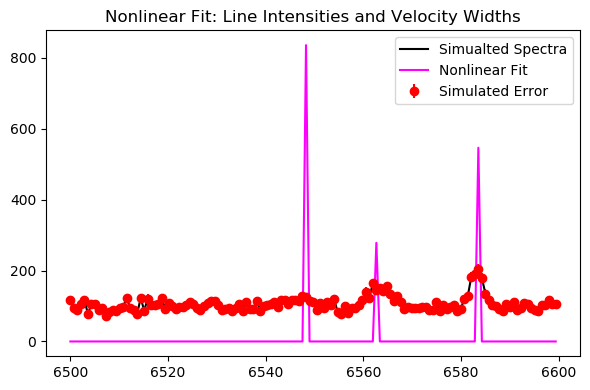

Derived Parameters: [1.e+03 1.e+03 1.e+03 1.e-01 1.e-01 1.e-01]
Errors on the parameters: [3.04729128e+09 8.30806905e+07 6.53946000e+08 8.46469993e+05
 3.24533967e+03 5.40451296e+04]
17599.67619616016 1.0


In [58]:
# fitting begins here
# nonlinear fit
# finding line intensities and velocity widths

def func_new(x,par1,par2,par3,par4,par5,par6) :
    """ Return normalized Gaussian function here for each of the 3 wavelengths.
    
    Input:
    x = wavelength array
    par1 = amplitude of 1st wave
    par2 = amplitude of 2nd wave
    par3 = amplitude of 3rd wave
    par4 = width of 1st wave
    par5 = width of 2nd wave
    par6 = width of 3rd wave
    
    Output:
    G1+G2+G3 = the added gaussian functions
    """
    

    G1 = par1*np.exp((-(x-6548.3)**2)/(2*par4**2))
    G2 = par2*np.exp((-(x-6562.8)**2)/(2*par5**2)) 
    G3 = par3*np.exp((-(x-6583.41)**2)/(2*par6**2)) 
    
    return  G1+G2+G3


# initial guesses
init = np.array([4000,6000,9000,7,10,6])
y_sim = out_sim
x_sim = waves_out_sim
sig_d = np.sqrt(y_sim + 3**2)

# curve fit process
popt, pcov = curve_fit(func_new,x_sim,y_sim,p0=init,sigma=sig_d,bounds=([1e3,1e3,1e3,0.1,0.1,0.1],[1e5,1e5,1e5,11,11,11]))

npar=6
freedom = (len(y_sim) - npar)
chi=sum((y_sim-func_new(x_sim,*popt))**2/sig_d**2)


plt.figure(dpi=100)
plt.title('Nonlinear Fit: Line Intensities and Velocity Widths')
plt.errorbar(x_sim,y_sim,sig_d,fmt='ro', label="Simulated Error")
plt.plot(x_sim,y_sim, color = 'black', label='Simualted Spectra')
plt.plot(x_sim,func_new(x_sim,*popt), color='magenta', label='Nonlinear Fit')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# errors on the diagonal
perr = np.sqrt(np.diag(pcov))
print('Derived Parameters:',popt)
print('Errors on the parameters:',perr)

print(chi,chi2.cdf(chi,len(out)-6))

For a simulated spectra of R=3000, sky = 100, S/N = 10, and RN = 3, the derived line intenities for each line are 
1.e+03, 1.e+03, and 1.e+03 and their derived velocity widths are 1.e-01, 1.e-01, and 1.e-01, respectively. The uncertainties are the parameters are 3.04729128e+09, 8.30806905e+07, 6.53946000e+08, 8.46469993e+05, 3.24533967e+03, and 5.40451296e+04, respectively. The $\chi^2$ value is 17599 with a probability of 1.

This is not a good fit.

----------

# Test 3

Kernel Delta lambda: 2.1833333333336973
Kernel sigma in pixels:  92


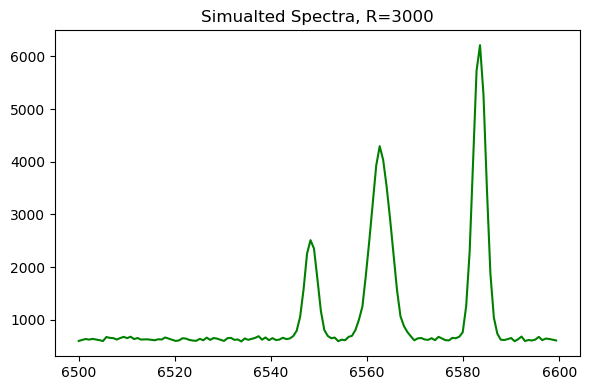

In [59]:
R = 3000
c = 3e5 #km/s
 
lines=[6548.3,6562.8,6583.41]   # [NII]6548, Ha6563, [NII]6583
amps=[100,300,300]            # relative amplitudes here
velwidths=[100,200,100]            # velocity widths
spec=np.zeros(len(waves))
for line,amp,vel in zip(lines,amps,velwidths) :
    spec+=mkline(waves,line,vel,amp)    # add in each line

plt.figure(dpi=100)
# simulate the observed spectrum
plt.title('Simualted Spectra, R=3000')
waves_out_sim,out_sim=specsim(waves,spec,R,sky=10,sn=25,rn=3)
plt.plot(waves_out_sim,out_sim,color='g')
plt.tight_layout()
plt.show()

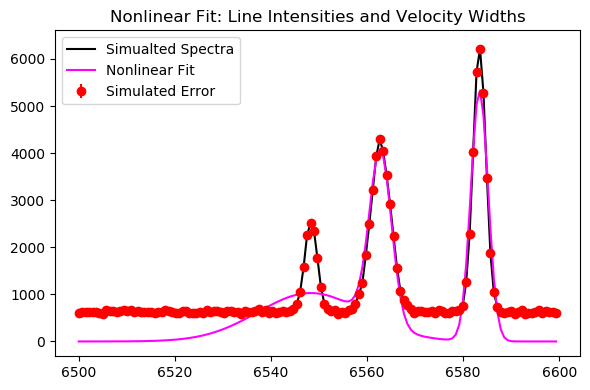

Derived Parameters: [1.02839377e+03 3.64616669e+03 5.33083613e+03 1.10000000e+01
 2.28543074e+00 1.79558820e+00]
Errors on the parameters: [1.29655955e+02 5.60088284e+02 7.20894298e+02 1.68814071e+00
 2.85875717e-01 1.61406516e-01]
45705.243339394474 1.0


In [61]:
# fitting begins here
# nonlinear fit
# finding line intensities and velocity widths

def func_new(x,par1,par2,par3,par4,par5,par6) :
    """ Return normalized Gaussian function here for each of the 3 wavelengths.
    
    Input:
    x = wavelength array
    par1 = amplitude of 1st wave
    par2 = amplitude of 2nd wave
    par3 = amplitude of 3rd wave
    par4 = width of 1st wave
    par5 = width of 2nd wave
    par6 = width of 3rd wave
    
    Output:
    G1+G2+G3 = the added gaussian functions
    """
    

    G1 = par1*np.exp((-(x-6548.3)**2)/(2*par4**2))
    G2 = par2*np.exp((-(x-6562.8)**2)/(2*par5**2)) 
    G3 = par3*np.exp((-(x-6583.41)**2)/(2*par6**2)) 
    
    return  G1+G2+G3


# initial guesses
init = np.array([4000,6000,9000,7,10,6])
y_sim = out_sim
x_sim = waves_out_sim
sig_d = np.sqrt(y_sim + 3**2)

# curve fit process
popt, pcov = curve_fit(func_new,x_sim,y_sim,p0=init,sigma=sig_d,bounds=([1e3,1e3,1e3,0.1,0.1,0.1],[1e5,1e5,1e5,11,11,11]))

npar=6
freedom = (len(y_sim) - npar)
chi=sum((y_sim-func_new(x_sim,*popt))**2/sig_d**2)


plt.figure(dpi=100)
plt.title('Nonlinear Fit: Line Intensities and Velocity Widths')
plt.errorbar(x_sim,y_sim,sig_d,fmt='ro', label="Simulated Error")
plt.plot(x_sim,y_sim, color = 'black', label='Simualted Spectra')
plt.plot(x_sim,func_new(x_sim,*popt), color='magenta', label='Nonlinear Fit')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# errors on the diagonal
perr = np.sqrt(np.diag(pcov))
print('Derived Parameters:',popt)
print('Errors on the parameters:',perr)

print(chi,chi2.cdf(chi,len(out)-npar))

For a simulated spectra of R=3000, sky = 10, S/N = 25, and RN = 3, the derived line intenities for each line are 
1.02839377e+03, 3.64616669e+03, and 5.33083613e+03 and their derived velocity widths are 1.10000000e+01, 2.28543074e+00, and 1.79558820e+00, respectively. The uncertainties are the parameters are 1.29655955e+02, 5.60088284e+02, 7.20894298e+02, 1.68814071e+00, 2.85875717e-01, and 1.61406516e-01, respectively. The $\chi^2$ value is 45705 with a probability of 1.

As can be seen, when the sky level increases, the fit looks worse rather than when the sky level is lower.



----------

d. Use your routine to derive line intensities for AGN_R3000.fits (Links to an external site.).  You should assume that the units of the spectrum is in detected electrons, so you can calculate the expected uncertainties; on top of the Poisson noise, you can assume a readout noise of 3 electrons.

In [63]:
AGN_R3000_file = fits.open('AGN_R3000.fits')
AGN_R3000_file2 = AGN_R3000_file[0].data

waves2=AGN_R3000_file[0].header['CRVAL1']+AGN_R3000_file[0].header['CDELT1']*np.arange(AGN_R3000_file[0].header['NAXIS1'])
R = 3000



Derived Parameters: [8.00000000e+02 8.00000000e+02 1.00000000e+03 1.00000000e+00
 2.97018205e+01 1.00000000e+00]
Errors on the parameters: [164.72566401  31.32644471 189.55901841   0.23056983   1.24192626
   0.20313195]
6857.47363358859 1.0


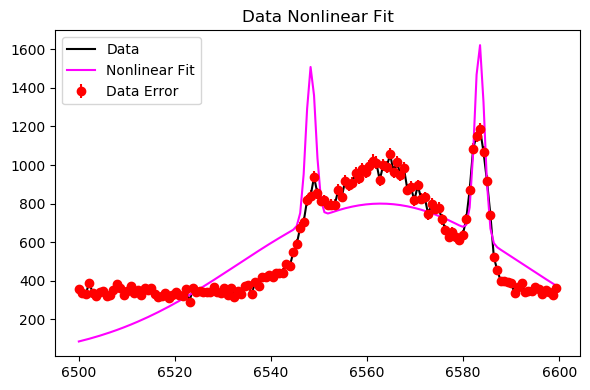

In [65]:
y_fits = AGN_R3000_file2
x_fits = waves2
init = np.array([900,1000,1200,2,30,4])
sig_d = np.sqrt(y_fits + 3**2)
popt, pcov = curve_fit(func_new,x_fits,y_fits,p0=init,sigma=sig_d,bounds=([800,800,1000,1,1,1],[1000,1000,1200,10,40,10]))

npar=6
freedom = (len(y_fits) - npar)
chi=sum((y_fits-func_new(x_fits,*popt))**2/sig_d**2)
# errors on the diagonal
perr = np.sqrt(np.diag(pcov))
print('Derived Parameters:',popt)
print('Errors on the parameters:',perr)

print(chi,chi2.cdf(chi,len(y_fits)-npar))

plt.figure(dpi=100)
plt.title('Data Nonlinear Fit')
plt.errorbar(x_fits,y_fits,sig_d,fmt='ro',label='Data Error')
plt.plot(x_fits,y_fits, color='black', label='Data')
plt.plot(x_fits,func_new(x_fits,*popt), color='magenta', label='Nonlinear Fit')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


No matter what I did, this is the best nonlinear fit. It is hard to fit all 3 peaks even with setting rigid bounds on what values can be obtained on the line intensities and velocity widths of the lines.